In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
device

device(type='cuda', index=0)

# Importing Libraries

In [1]:
!wget https://raw.githubusercontent.com/diegoalejogm/gans/master/utils.py

--2020-08-08 09:15:03--  https://raw.githubusercontent.com/diegoalejogm/gans/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4866 (4.8K) [text/plain]
Saving to: ‘utils.py.2’

utils.py.2          100%[===================>]   4.75K  --.-KB/s    in 0s      

2020-08-08 09:15:03 (66.5 MB/s) - ‘utils.py.2’ saved [4866/4866]



In [1]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.autograd.variable import Variable
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def mnist_data():
  compose = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((.5,), (.5,))])
  out_dir = './datasets'
  return datasets.MNIST(out_dir, train=True, transform=compose, download = True)

In [3]:
data = mnist_data()

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw


Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
dataloader = torch.utils.data.DataLoader(data, batch_size = 100, shuffle = True)
num_batches = len(dataloader)

In [5]:
num_batches

600

Visualizing data

In [10]:
def show_image(images, nrows = 5, ncols = 5):
  fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex = True, sharey=True, figsize = (10,10))
  m = images.size(0)
  for i in range(nrows):
    for j in range(ncols):
      num = np.random.randint(m)
      axes[i][j].imshow(images[num, 0], cmap = plt.cm.binary_r)
      axes[i][j].axis('off')
  plt.show()

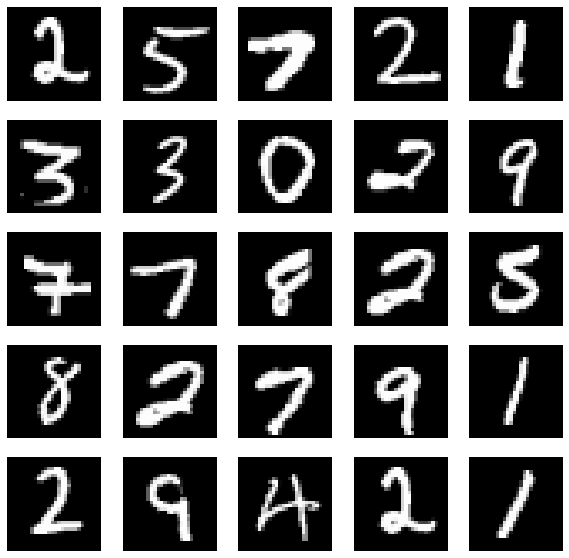

In [11]:
(x,y) = next(iter(dataloader))
show_image(x)

# Architecture

In [29]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()
    n_features = 28 * 28
    n_out = 1
    alpha = 0.2
    prob = 0.3
    self.hidden0 = nn.Sequential(
        nn.Linear(n_features, 1024),
        nn.LeakyReLU(alpha),
        nn.Dropout(prob)
    )

    self.hidden1 = nn.Sequential(
        nn.Linear(1024, 512),
        nn.LeakyReLU(alpha),
        nn.Dropout(prob)
    )

    self.hidden2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.LeakyReLU(alpha),
        nn.Dropout(prob)
    )

    self.out = nn.Sequential(
        nn.Linear(256,n_out),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.hidden0(x)
    x = self.hidden1(x)
    x = self.hidden2(x)
    x = self.out(x)
    return x

discriminator = Discriminator().to(device)

In [30]:
def images_to_vector(imgs):
  return imgs.view(imgs.size(0), 784)

def vector_to_image(vector):
  return vector.view(vector.size(0), 1, 28,28)

In [31]:
class Generator(nn.Module):

  def __init__(self):
    super(Generator, self).__init__()
    
    z_dim = 100
    n_out = 784
    alpha = 0.2

    self.hidden0 = nn.Sequential(
        nn.Linear(z_dim, 256),
        nn.LeakyReLU(alpha)
    )

    self.hidden1 = nn.Sequential(
        nn.Linear(256, 512),
        nn.LeakyReLU(alpha)
    )

    self.hidden2 = nn.Sequential(
        nn.Linear(512, 1024),
        nn.LeakyReLU(alpha)
    )

    self.out = nn.Sequential(
        nn.Linear(1024, n_out),
        nn.Tanh()
    )

  def forward(self, x):

    x = self.hidden0(x)
    x = self.hidden1(x)
    x = self.hidden2(x)
    x = self.out(x)
    return x

generator = Generator().to(device)

In [32]:
# Sample latent dim

def noise(size):
  n = Variable(torch.randn((size,100))).to(device)

  return n

def ones_target(size):
  data = Variable(torch.ones(size, 1)).to(device)
  return data

def zeros_target(size):
  data = Variable(torch.zeros(size, 1)).to(device)
  return data

In [33]:
d_optimizer = optim.Adam(discriminator.parameters(), lr = 0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr = 0.0002)

In [34]:
loss = nn.BCELoss()

In [35]:
def train_discriminator(optimizer, real_data, fake_data):
  N = real_data.size(0)

  optimizer.zero_grad()

  prediction_real = discriminator(real_data)
  error_real = loss(prediction_real, ones_target(N))
  error_real.backward()

  prediction_fake = discriminator(fake_data)
  error_fake = loss(prediction_fake, zeros_target(N))
  error_fake.backward()

  optimizer.step()

  return error_real + error_real, prediction_real, prediction_fake

In [36]:
def train_generator(optimizer, fake_data):
  N = fake_data.size(0)

  optimizer.zero_grad()

  prediction = discriminator(fake_data)
  
  error = loss(prediction, ones_target(N))
  error.backward()

  optimizer.step()

  return error, prediction

In [37]:
num_test_examples = 25
test_noise = noise(num_test_examples)

In [38]:
def VGAN(epochs, sample_iteration):
  logs = []
  for epoch in range(epochs + 1):
    for n_batch, (real_data,_) in enumerate(dataloader):
      N = real_data.size(0)
      real_data = Variable(images_to_vector(real_data)).to(device)
      latent_dim = noise(N)
      fake_data = generator(latent_dim).detach()

      d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)

      fake_data = generator(noise(N))

      g_error, g_pred = train_generator(g_optimizer, fake_data)

      logs.append([d_error, g_error, epoch, n_batch])

    if epoch % sample_iteration == 0:

      print("Displaying image for Epoch {}/{}".format(epoch, epochs))
      test_images = vector_to_image(generator(test_noise))
      test_images = test_images.data.cpu()
      show_image(test_images)

Displaying image for Epoch 0/200


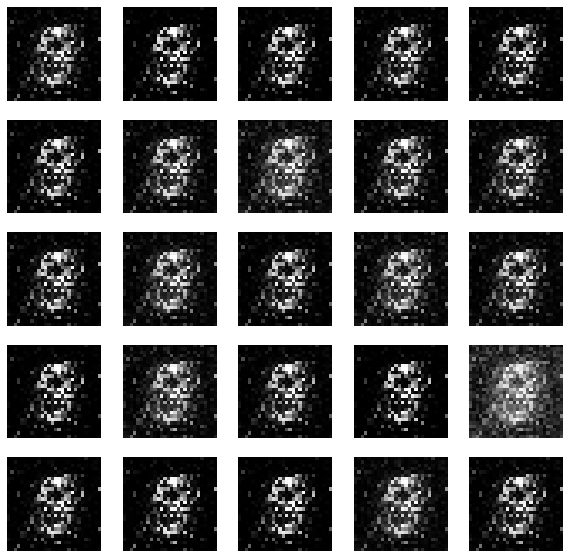

Displaying image for Epoch 10/200


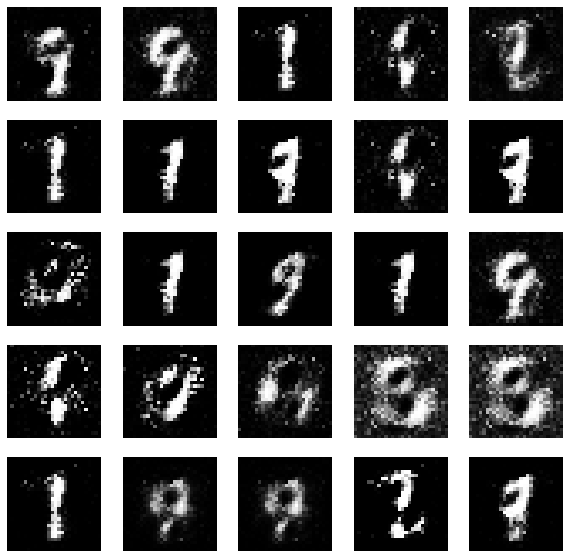

Displaying image for Epoch 20/200


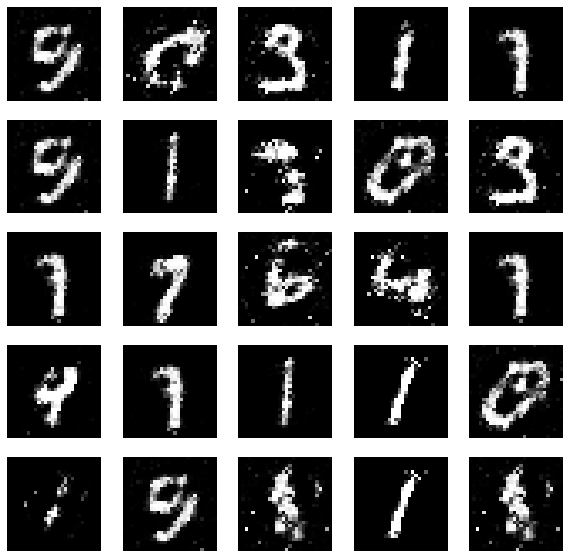

Displaying image for Epoch 30/200


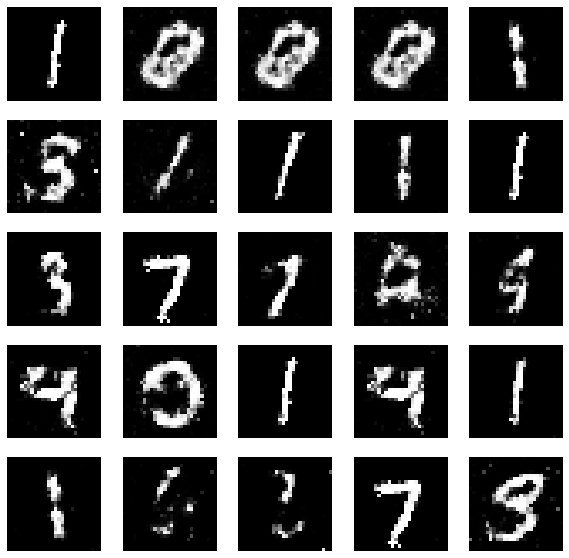

Displaying image for Epoch 40/200


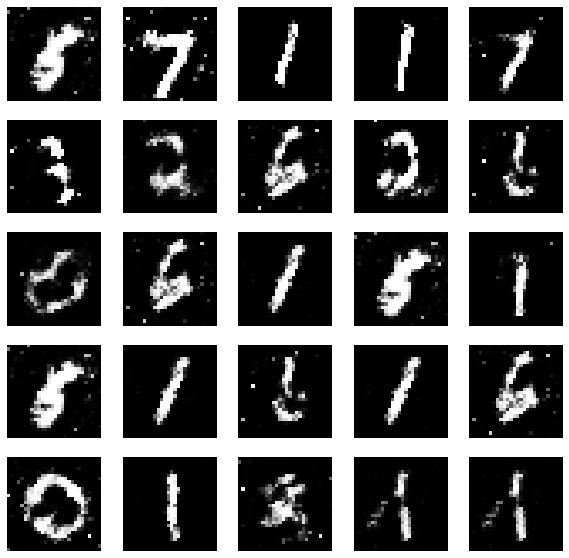

Displaying image for Epoch 50/200


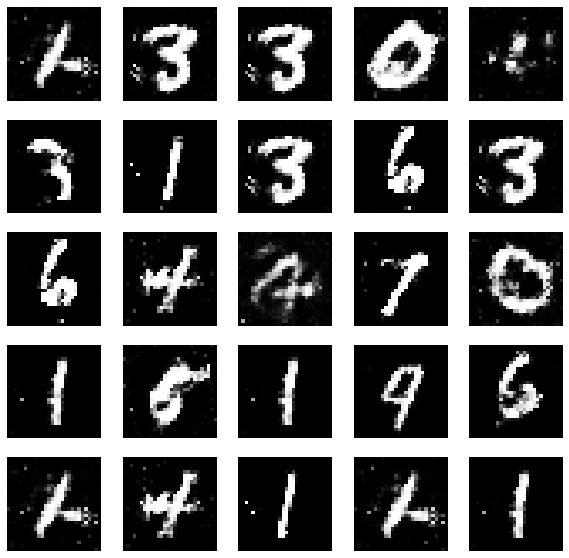

Displaying image for Epoch 60/200


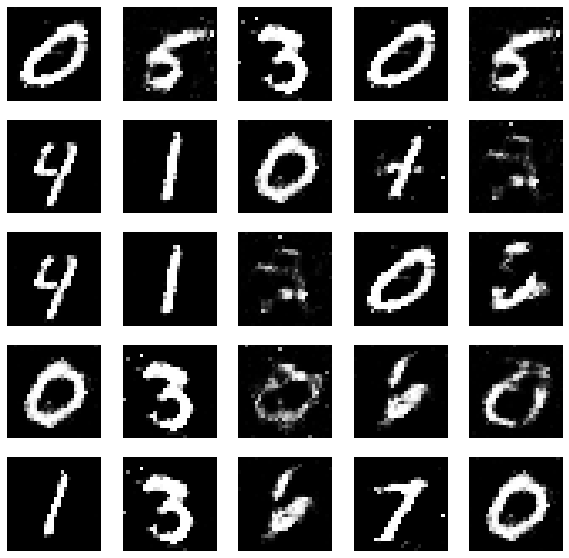

Displaying image for Epoch 70/200


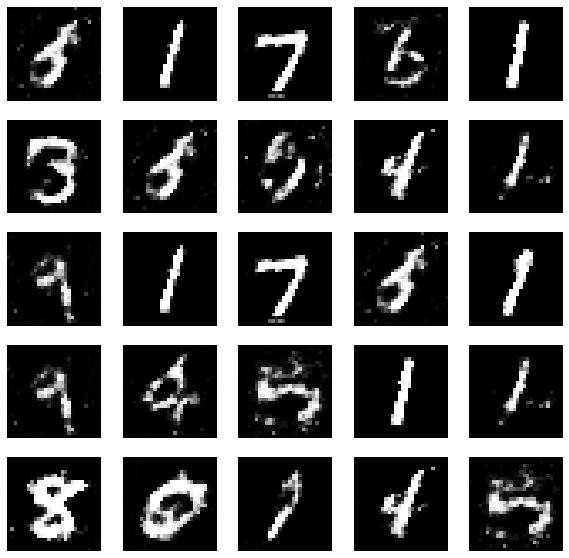

Displaying image for Epoch 80/200


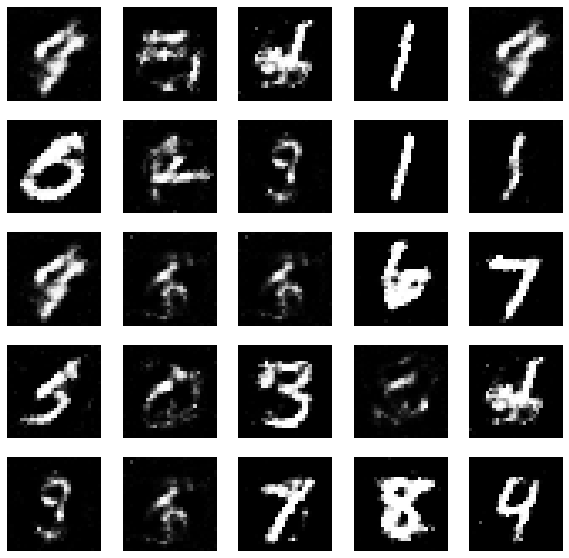

Displaying image for Epoch 90/200


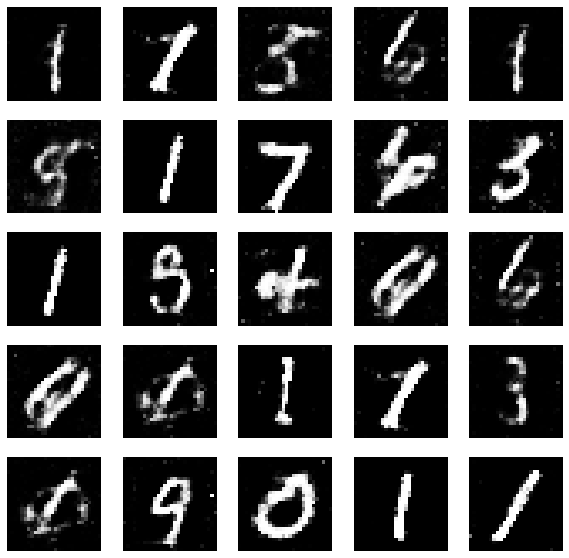

Displaying image for Epoch 100/200


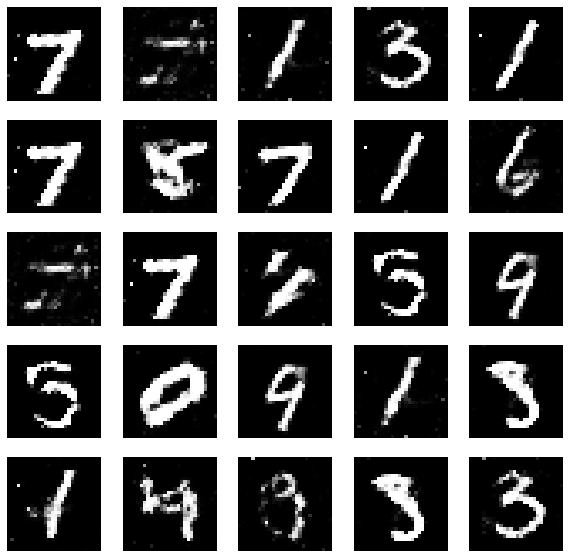

Displaying image for Epoch 110/200


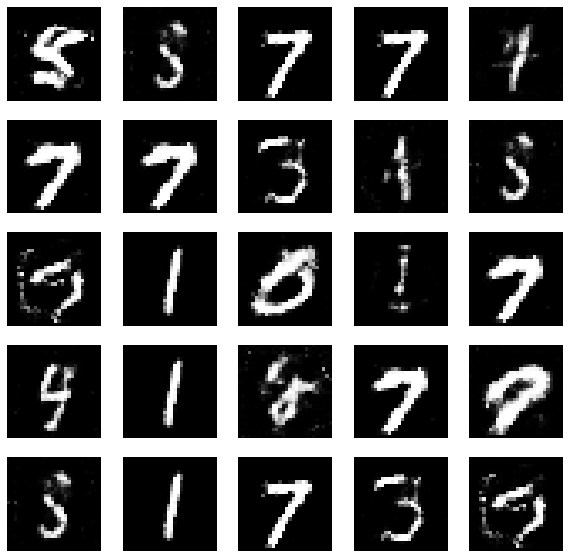

Displaying image for Epoch 120/200


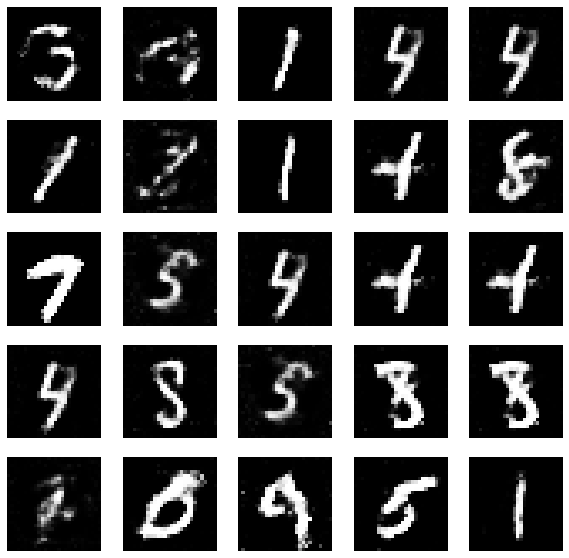

Displaying image for Epoch 130/200


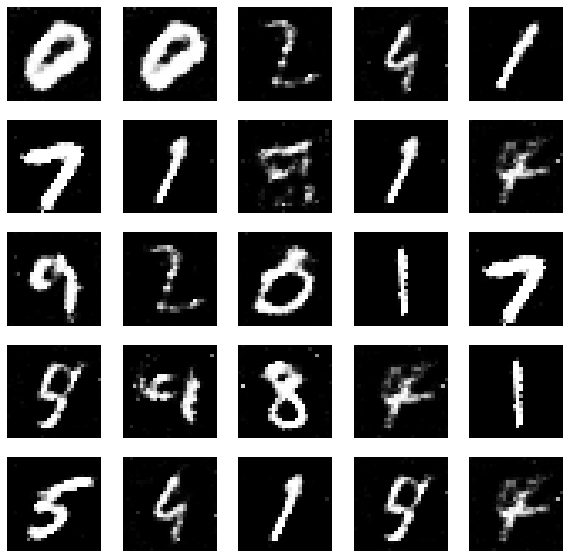

Displaying image for Epoch 140/200


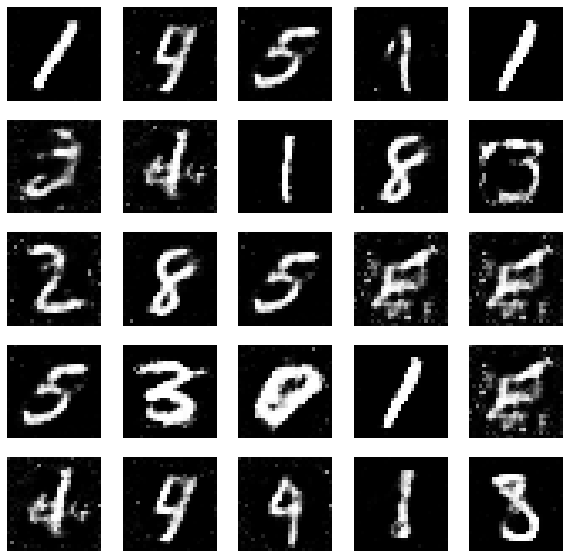

Displaying image for Epoch 150/200


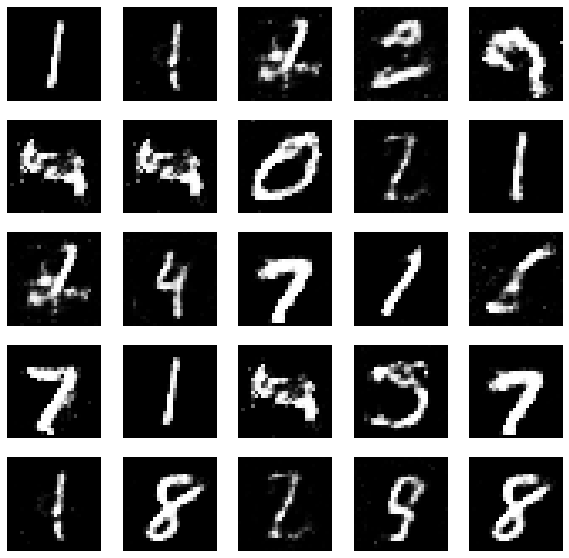

Displaying image for Epoch 160/200


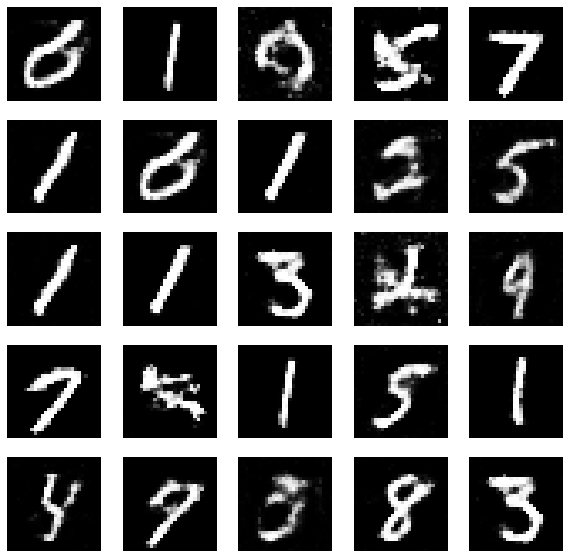

Displaying image for Epoch 170/200


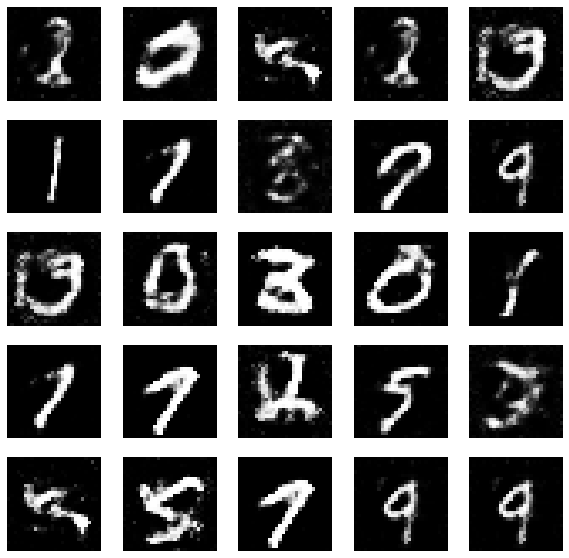

Displaying image for Epoch 180/200


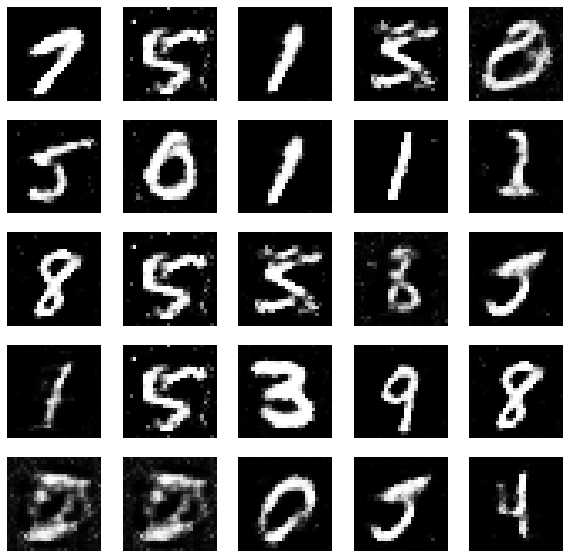

Displaying image for Epoch 190/200


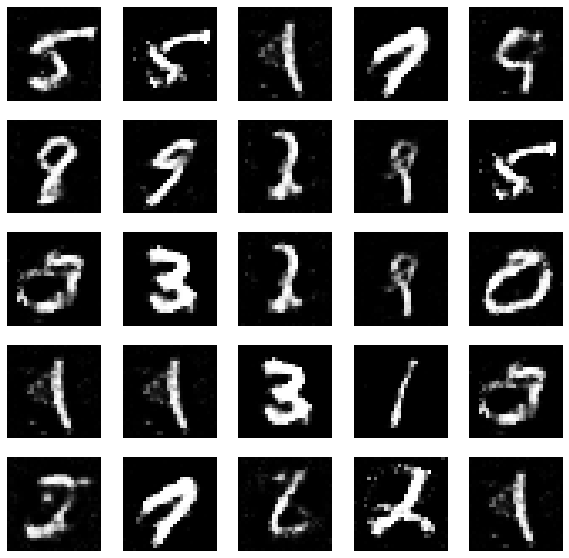

Displaying image for Epoch 200/200


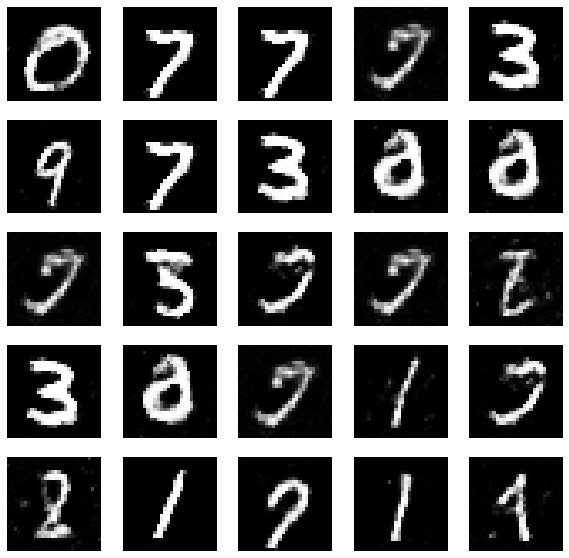

In [39]:
VGAN(200, 10)

In [40]:
num_test = 100
test_noise = noise(num_test)

In [41]:
prediction = vector_to_image(generator(test_noise)).data.cpu()

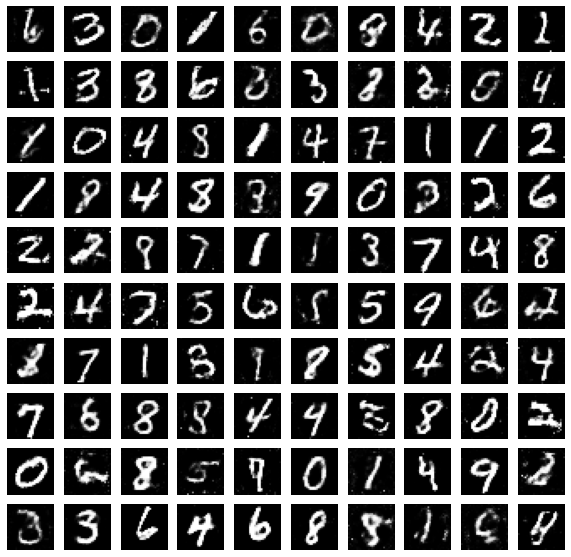

In [42]:
def show_image(images, nrows = 5, ncols = 5):
  fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex = True, sharey=True, figsize = (10,10))
  m = images.size(0)
  count = 0
  for i in range(nrows):
    for j in range(ncols):
      axes[i][j].imshow(images[count, 0], cmap = plt.cm.binary_r)
      axes[i][j].axis('off')
      count += 1
  plt.show()
show_image(prediction, nrows = 10, ncols = 10)